# Simulation Analysis Notebook

This Jupyter Notebook is designed to introduce a user to the PyGkyl library (unofficial naming). 
It includes many different examples of diagnostic tools that can be used to analyze Gkeyll GK simulation data. 

Antoine C.D. Hoffmann (@antoinehoff) -- Jan 13, 2025

## Table of Contents
1. [Prologue](#prologue)<br>
    1.1 [Setup and Imports](#setup_imports)<br>
    1.2 [Simulation Data Setup](#data_setup)<br>
    1.3 [Simulation Class Initialization](#simulation_class)<br>
    1.4 [Source Profiles and Input Power](#sources)<br>
    1.5 [Time Frame and normalization](#time_frames)<br>

2. [Simulation Data Analysis](sim_analysis)<br>
    2.1 [1D Profile Relaxation](#1d_profile)<br>
    2.2 [Space-Time Diagrams](#space_time)<br>
    2.3 [Two-Dimensional Cut](#2d_cut)<br>
    2.4 [Space-Time Fluctuation](#st_fluct_plot)<br>
    2.5 [Two-Dimensional Fluctuation](#2d_fluct_plot)<br>
    2.6 [Time-Averaged Profile](#time_averaged_profile)<br>
    2.7 [Flux Surface Time-Average Profiles](#fs_time_averaged_profile)<br>
    2.8 [Volume Integral Quantities](#volume_integrals)<br>
    2.9 [Grad B Loss](#gradb_loss)<br>
    2.10 [Movie Generator](#movie_generator)<br>
    2.11 [Phase Space Analysis](#dist_funct)<br>

## 1. Prologue <a id="prologue"></a>
This section imports necessary libraries and custom routines required for the analysis. It also builds a Simulation class instance that will deliver helpful data to the plotting routine. Finally, it looks for the available simulation frames.

### 1.1 Simulation Data Path <a id="data_setup"></a>
Set up the path to the simulation data and its file prefix.

In [1]:
simdir = 'sim_data_dir_example/3x2v_example/gk_tcv_posD_iwl_3x2v_electron_heating/'
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02'

### 1.2 Import PyGkyl <a id="setup_import"></a>
Import the pygkyl library

In [19]:
'''Uncomment the four following lines if you need to reinstall it'''
# import sys
# !rm -rf ~/personal_gkyl_scripts/pygkyl/pygkyl.egg-info
# !rm -rf ~/personal_gkyl_scripts/pygkyl/build
# !{sys.executable} -m pip install ~/personal_gkyl_scripts/pygkyl > ~/personal_gkyl_scripts/pygkyl/install.log
from pygkyl import Simulation, Species, file_utils, Source, plot_utils

### 1.3 Simulation Class Initialization <a id="simulation_class"></a>
Initialize the `Simulation` class (see /python_utilities/classes/simulation.py) and set physical and geometric parameters.

The simulation class is made to contain every parameter and information about the simulation we want to analyze. It is meant to store geometry, metric, where the data are located and how they were generated. It will be used by all plot and post processing routines.

For now we pass many simulation parameters manually as not all simulation parameters are stored in the output file metadata. This will be adapted later to read directly from the lua script that ran the simulation.

In [3]:
simulation = Simulation(dimensionality='3x2v')
simulation.set_phys_param(
    B_axis = 1.4,           # Magnetic field at magnetic axis [T]
    eps0 = 8.854e-12,       # Vacuum permittivity [F/m]
    eV = 1.602e-19,         # Elementary charge [C]
    mp = 1.673e-27,         # Proton mass [kg]
    me = 9.109e-31,         # Electron mass [kg]
)
simulation.set_geom_param(
    R_axis      = 0.8727315068,         # Magnetic axis major radius
    Z_axis      = 0.1414361745,         # Magnetic axis height
    R_LCFSmid   = 1.0968432365089495,   # Major radius of LCFS at the midplane
    a_shift     = 0.25,                 # Parameter in Shafranov shift
    kappa       = 1.5,                 # Elongation factor
    delta       = 0.3,                 # Triangularity factor
    q0          = None,                 # Safety factor
    x_LCFS      = 0.04,                 # position of the LCFS (= core domain width)
    x_out       = 0.08                  # SOL domain width
)
# Define the species
ion = Species(name='ion',
              m=2.01410177811*simulation.phys_param.mp, # Ion mass
              q=simulation.phys_param.eV,               # Ion charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
elc = Species(name='elc',
              m=simulation.phys_param.me, 
              q=-simulation.phys_param.eV, # Electron charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
# Add them to the simulation (we need to know this before setting up the data parameters)
simulation.add_species(ion)
simulation.add_species(elc)
# This call will set up the data structure of the simulation and set up a large dictionary 
# conaining the receipes of many post processing quantities, see simulation.data_param.info()
simulation.set_data_param( simdir = simdir, fileprefix = fileprefix, species = simulation.species)
# This is the first call that will load data. 
# If the paths are not set up correctly, the script will fail here.
simulation.geom_param.load_metric(simulation.data_param.fileprefix)

### 1.4 Source Profiles and Input Power <a id="sources"></a>
Define source profiles and calculate input power and particle flux.

The sources are passed to the previously defined parameters to the Simulation instance.

A small print will display the input of energy and particle by a volume integration of the source profiles using the the Jacobian loaded in the metric.

-- Source Informations --
Total input particle: 4.92824e+21 part/s
Total input power: 396.009 kW


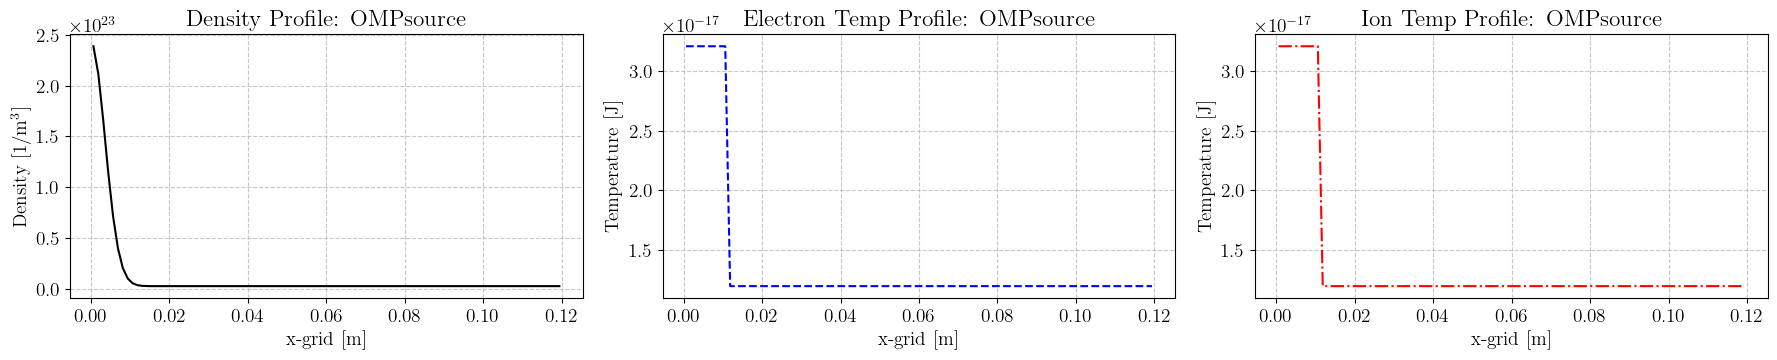

In [4]:
import numpy as np
n_srcOMP=2.4e23
x_srcOMP=0.0
Te_srcOMP=2 * simulation.species['elc'].T0
Ti_srcOMP=2 * simulation.species['ion'].T0
sigma_srcOMP=0.03 * simulation.geom_param.Lx
floor_src=1e-2
def custom_density_src_profile(x,y,z):
    return n_srcOMP * (np.exp(-((x - x_srcOMP) ** 2) / (2.0 * sigma_srcOMP ** 2)) + floor_src)
def custom_temp_src_profile_elc(x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Te_srcOMP; fout[~mask] = Te_srcOMP * 3.0 / 8.0
    return fout  
def custom_temp_src_profile_ion( x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Ti_srcOMP; fout[~mask] = Ti_srcOMP * 3.0 / 8.0
    return fout   
OMPsource = Source(n_src=n_srcOMP,x_src=x_srcOMP,Te_src=Te_srcOMP,Ti_src=Ti_srcOMP,
                   sigma_src=sigma_srcOMP,floor_src=floor_src,
                   density_src_profile=custom_density_src_profile,
                   temp_src_profile_elc=custom_temp_src_profile_elc,
                   temp_src_profile_ion=custom_temp_src_profile_ion)
simulation.add_source('OMPsource',OMPsource)
simulation.source_info(type='profile', y_const=0, z_const=0)

### 1.5 Time Frame and normalization <a id="time_frames"></a>
Load available time frames and integrated moment diagnostics.

We can set up different units for the plots. These calls will adapt automatically all plotting routine, setting up the axes accordingly.

We also look for all available frames, i.e. we look for all number XX in "[fileprefix]-[fieldname]_XX.gkyl"

In [5]:
simulation.normalize('t','mus') # time in micro-seconds
simulation.normalize('x','minor radius') # radial coordinate normalized by the minor radius (rho=r/a)
simulation.normalize('y','Larmor radius') # binormal in term of reference sound Larmor radius
simulation.normalize('z','pi') # parallel angle devided by pi
simulation.normalize('fluid velocities','thermal velocity') # fluid velocity moments are normalized by the thermal velocity
simulation.normalize('temperatures','eV') # temperatures in electron Volt
simulation.normalize('pressures','Pa') # pressures in Pascal
simulation.normalize('energies','MJ') # energies in mega Joules

fieldname = fileprefix+'-field' #e.g. we check the electrostatic field files.
sim_frames = file_utils.find_available_frames(simulation,fieldname)
print("Time frames available from %g to %g"%(sim_frames[0],sim_frames[-1]))

Time frames available from 0 to 231


## 2. Simulation Data Analysis <a id="sim_analysis"></a>
We now use the plot routines defined in `python_utilities/tools/plot_utils.py` to generated various plots from the Simulation instance.

### 2.1 Profile relaxation <a id="1d_profile"></a>
Generate a 2D cut plot at a specified plane and time frame.
- `cut_direction`   The dimension that remains after the cut. Can be 'x','y','z' and 'ky'.
- `cut_coords`      The coordinate of the cut, can be a double corresponding to the physical position (in the normalized units defined above), an integer to select an index or 'avg' to average over the dimension.
- `fieldnames`      The fields we want to plot. An array of char will create a multi plot. (see simulation.display_available_fields())
- `frames`          The frames to plot


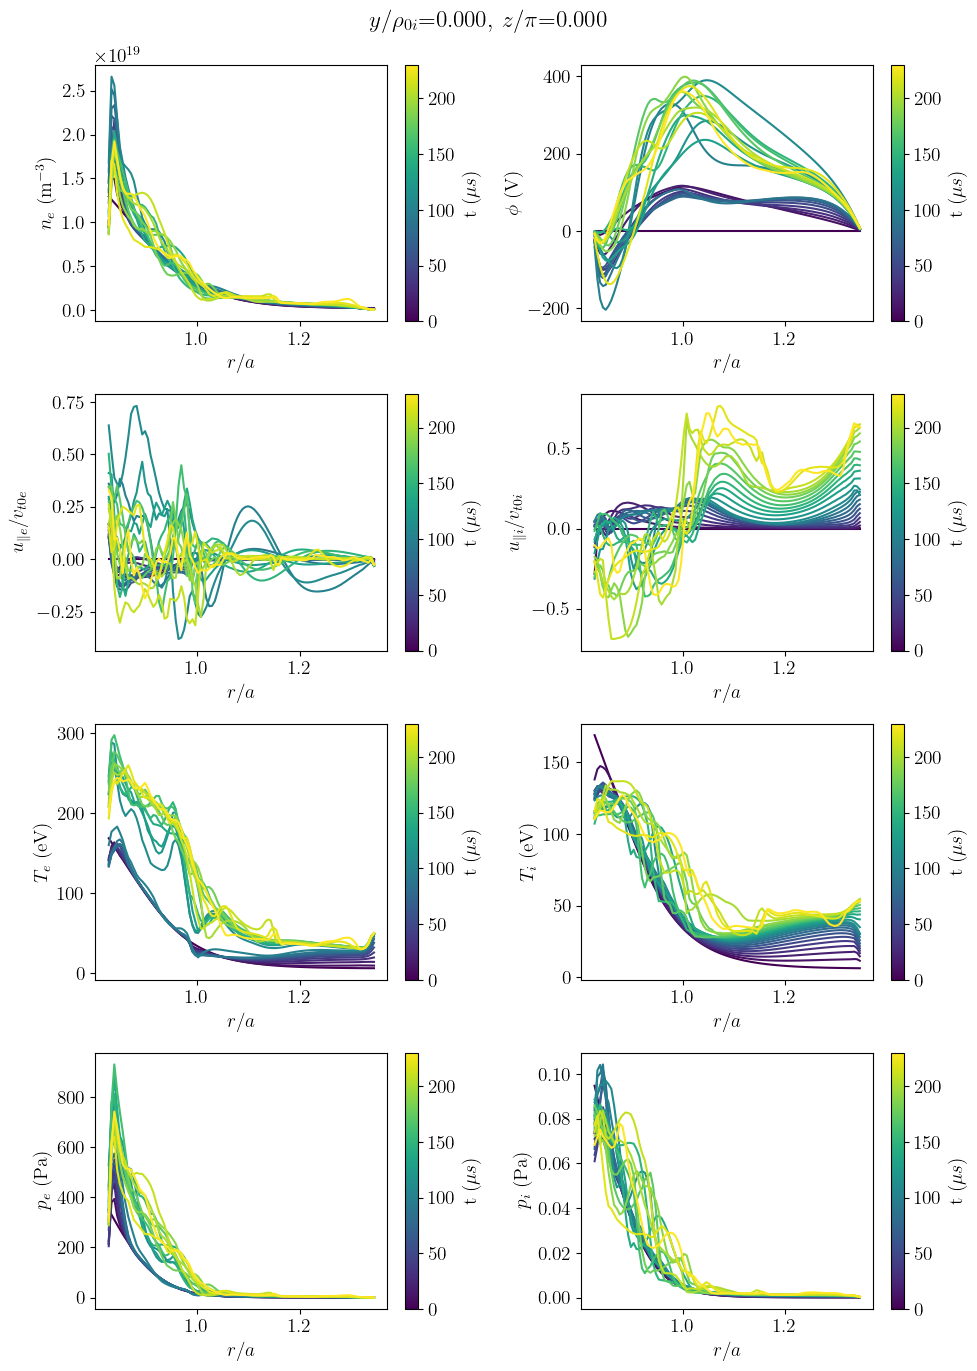

In [6]:
cut_direction='x' 
cut_coords=[0.0,0.0]
fieldnames = ['ne','phi','upare','upari','Te','Ti','pe','pi']
frames = sim_frames[::10]
plot_utils.plot_1D_time_evolution(simulation,cut_direction,cut_coords,fieldnames,frames,space_time = False)

### 2.2 Space-Time Diagrams <a id="space_time"></a>
Generate space-time diagrams for specified fields. Very useful to see the dynamics without a movie

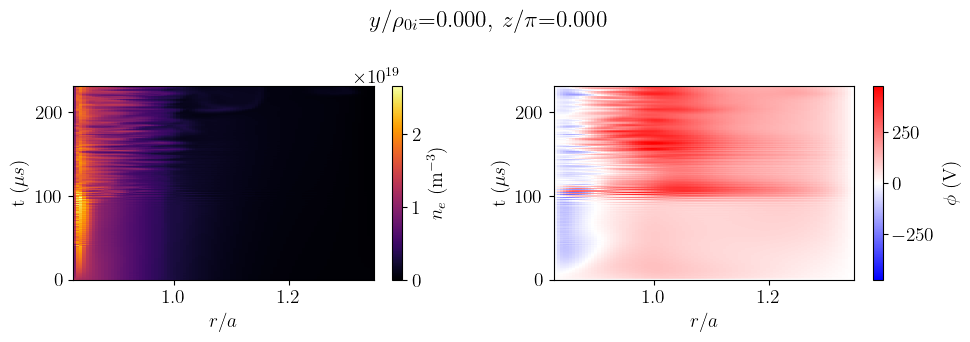

In [7]:
cut_dir = 'x'
cut_coord = [0.0, 0.0]
fieldnames = ['ne', 'phi']
frames = sim_frames[:]
plot_utils.plot_1D_time_evolution(simulation, cut_dir, cut_coord, fieldnames, frames, space_time=True)

### 2.3 Two-dimensional Cut <a id="2d_cut"></a>
Generate a 2D cut plot at a specified plane and time frame.

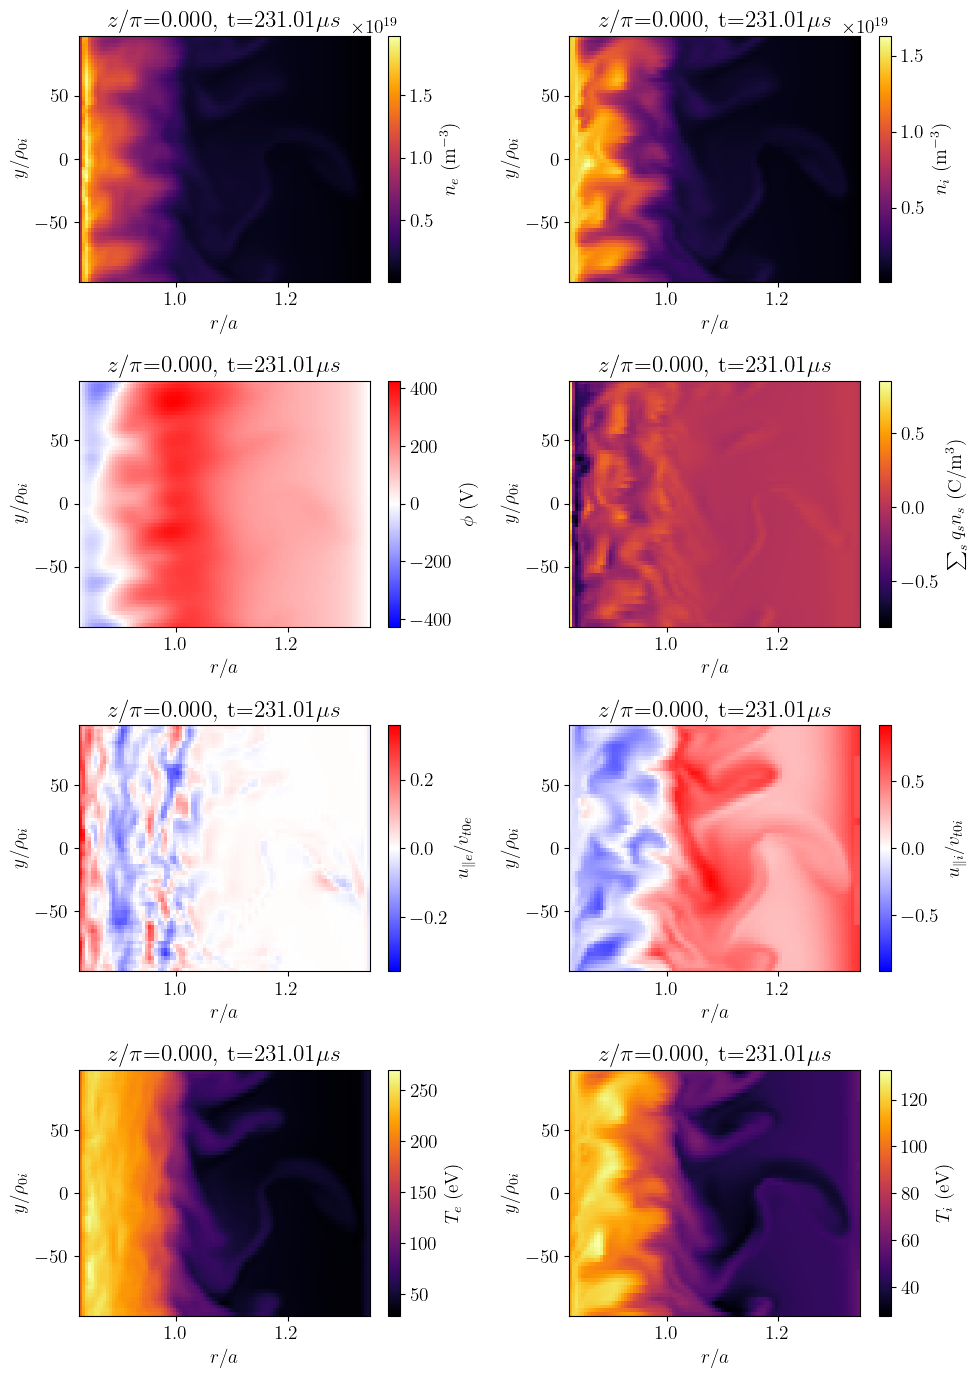

In [8]:
cut_dir = 'xy' # the plane we want to plot
cut_coord = 0.0 # the coordinate were the plan stands If normalized units are defined, 
# this number is in the normalize units. One can also specify a integer for array index 
# or 'avg' to get an average over the reduced dim.
time_frame = sim_frames[-1] # the time frame
fieldnames = ['ne', 'ni', 'phi', 'qdens', 'upare', 'upari', 'Te', 'Ti'] # the fields to plot, see simulation.display_available_fields() (some may not work in 2x2v)
plot_utils.plot_2D_cut(simulation, cut_dir, cut_coord, time_frame, fieldnames)

### 2.4 Space Time and 2D cut Fluctuation <a id="st_fluct_plot"></a>
Generate a fluctuation plot by averaging over a time window and then substracting this average to each time frame. The average is performed against time only. If `coords` is set to be 'avg', additional averages are performed for both background and fluctuations.

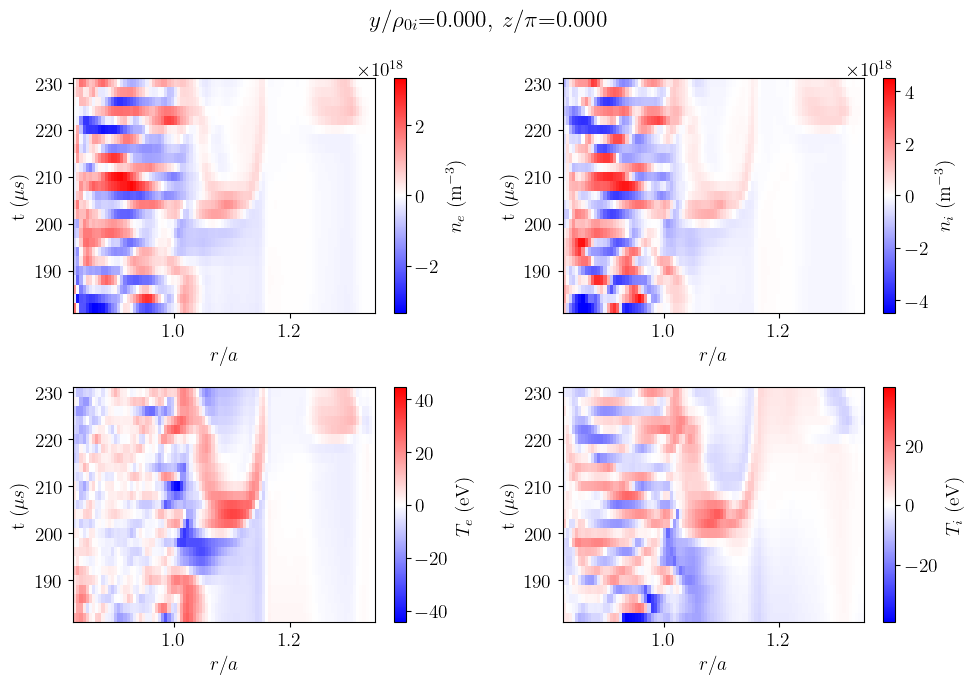

In [9]:
cut_direction='x' 
cut_coords=[0.0,0.0]
fieldnames = ['ne','ni','Te','Ti']
frames = sim_frames[-50::2]
plot_utils.plot_1D_time_evolution(
    simulation,cut_direction,cut_coords,fieldnames,frames,
    space_time = True, fluctuation = True,)

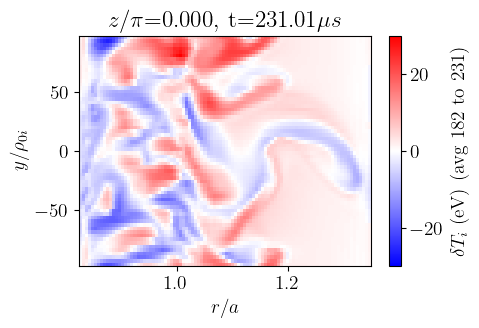

In [10]:
#---------- 2D cut plot
#-- choose min and max time frames and cut location
cplane='xy'; ccoord =0.0
plot_utils.plot_2D_cut(simulation, cplane, ccoord, 
            time_frame = sim_frames[-50:], 
            fieldnames = ['Ti'],
            fluctuation = True,
            cmap = 'bwr'
            )

### 2.5 Two-Dimensional Fluctuation <a id="2d_fluct_plot"></a>
Display the fluctuation of a field on a 2D plane

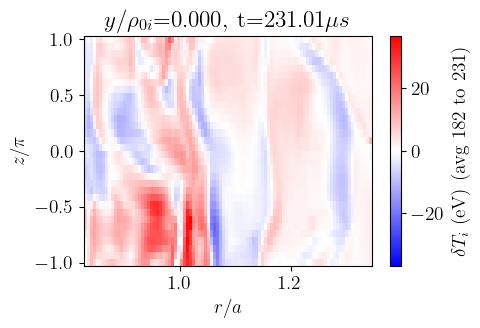

In [11]:
cplane='xz' 
ccoord = 0.0
frames = sim_frames[-50:]
fieldnames = ['Ti']
plot_utils.plot_2D_cut(
    simulation, cplane, ccoord, frames, fieldnames,
    time_average = False,fluctuation = True,)

### 2.6 Time-Averaged Profile  <a id="time_averaged_profile"></a>
Here we show the ExB shear averaged over time of the last 50 frames. We generate also error bars that are related to the standard deviation.

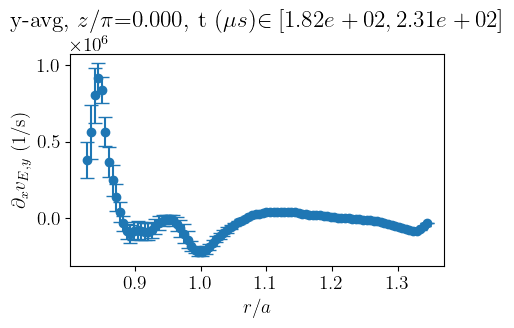

In [12]:
cdirection='x'
ccoords=['avg',0.0]
fieldnames = ['sExBy_x']
time_frames = sim_frames[-50:]
plot_utils.plot_1D(
    simulation,cdirection,ccoords,fieldnames,
    time_frames, errorbar = True,)

### 2.7 Flux Surface Time-Average Profiles <a id="fs_time_averaged_profile"></a>
We also add a small example on how to save the figure and replot it.

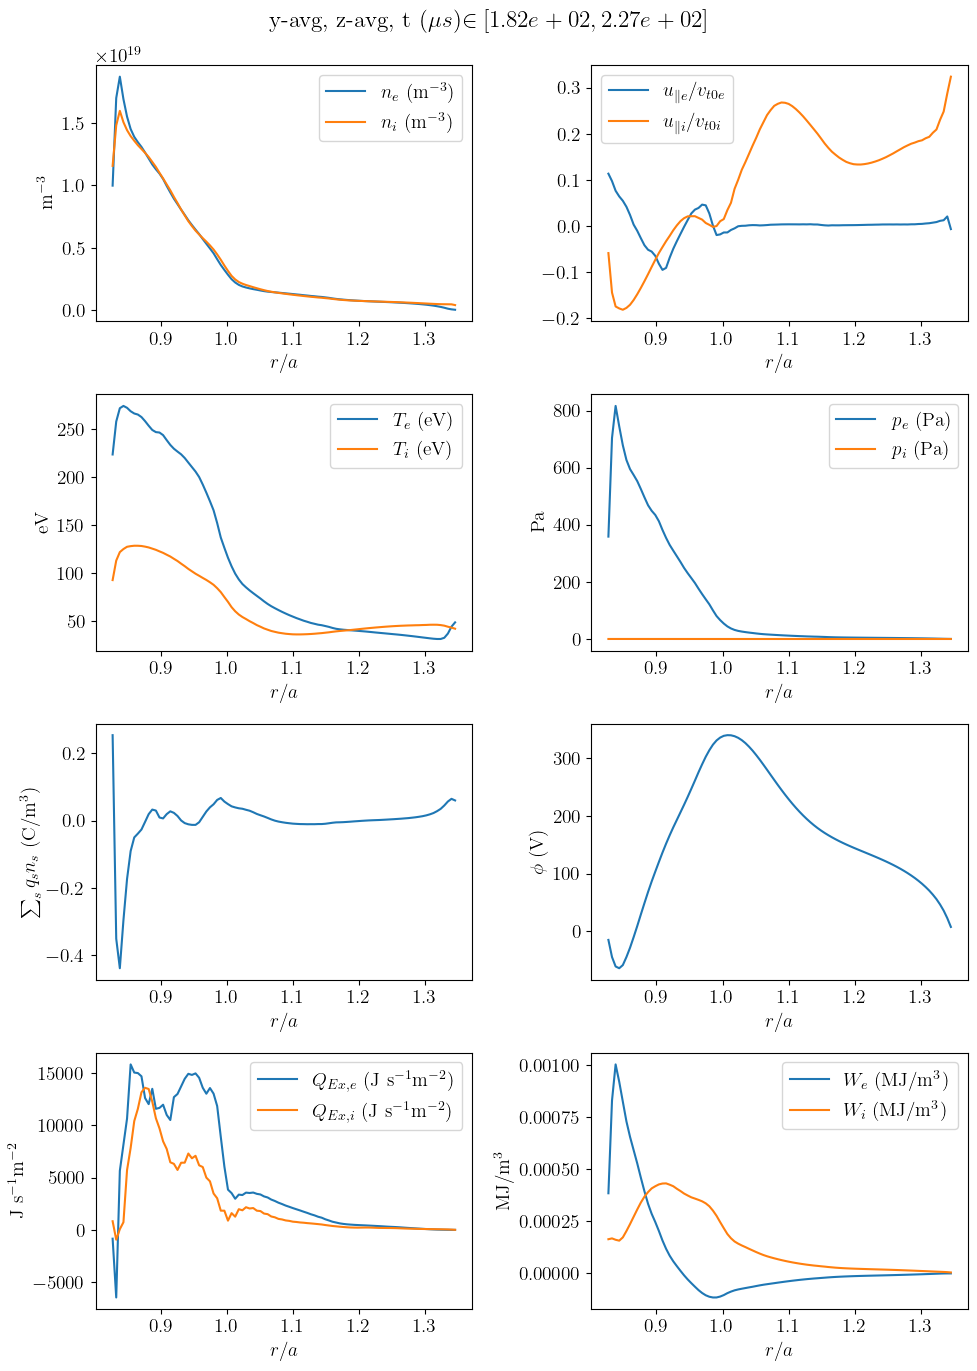

In [13]:
figout = []
cdirection='x'; ccoords=['avg','avg']
plot_utils.plot_1D(
        simulation,cdirection,ccoords,
        fieldnames = [['ne','ni'],['upare','upari'],
                      ['Te','Ti'],['pe','pi'],
                      'qdens','phi',
                      ['ExB_hflux_xe','ExB_hflux_xi'], ['Wtote','Wtoti']
                     ],
        time_frames = sim_frames[-50::5], errorbar = False, figout = figout
        )
# save_figout(figout,'fig_profiles') # this allows you to reload and replot with additional data

#------- Here is an example for reploting and overlaying data
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (6,4)
# plt.rcParams["font.size"] = 16
# figdatadict = load_figout('fig_profiles')

# n_plot = figdatadict[0]
# ne_sim = n_plot['curves'][0]
# ne_exp = {}
# ne_exp['label'] =r'$n_e^{exp}$';
# data = np.loadtxt('ne_exp.txt', delimiter=',') 
# ne_exp['xdata'] = data[:,0]/simulation.normalization['xscale']+1;
# ne_exp['ydata'] = data[:,1];

# plt.plot(ne_sim['xdata'],ne_sim['ydata'],label=ne_sim['label'])
# plt.plot(ne_exp['xdata'],ne_exp['ydata'],'ok',label=ne_exp['label'])
# plt.legend()
# plt.ylabel(r'1/m${^3}$')
# plt.xlabel('r/a')
# plt.show()

# T_plot = figdatadict[2]
# Te_sim = T_plot['curves'][0]
# Te_exp = {}
# Te_exp['label'] =r'$T_e^{exp}$';
# data = np.loadtxt('Te_exp.txt', delimiter=',') 
# Te_exp['xdata'] = data[:,0]/simulation.normalization['xscale']+1;
# Te_exp['ydata'] = data[:,1];

# plt.plot(Te_sim['xdata'],Te_sim['ydata'],label=Te_sim['label'])
# plt.plot(Te_exp['xdata'],Te_exp['ydata'],'ok',label=Te_exp['label'])
# plt.legend()
# plt.ylabel('eV')
# plt.xlabel('r/a')
# plt.show()

### 2.8 Volume Integral Quantities <a id="volume_integrals"></a>
Plot volume-integrated quantities such as energies over time.

Processing: Field 1/4, Subfield 3/3, Frame 24/24Total input power: 396.009 kW

Processing: Field 2/4, Subfield 2/2, Frame 24/24
Processing: Field 3/4, Subfield 2/2, Frame 24/24
Processing: Field 4/4, Subfield 2/2, Frame 24/24


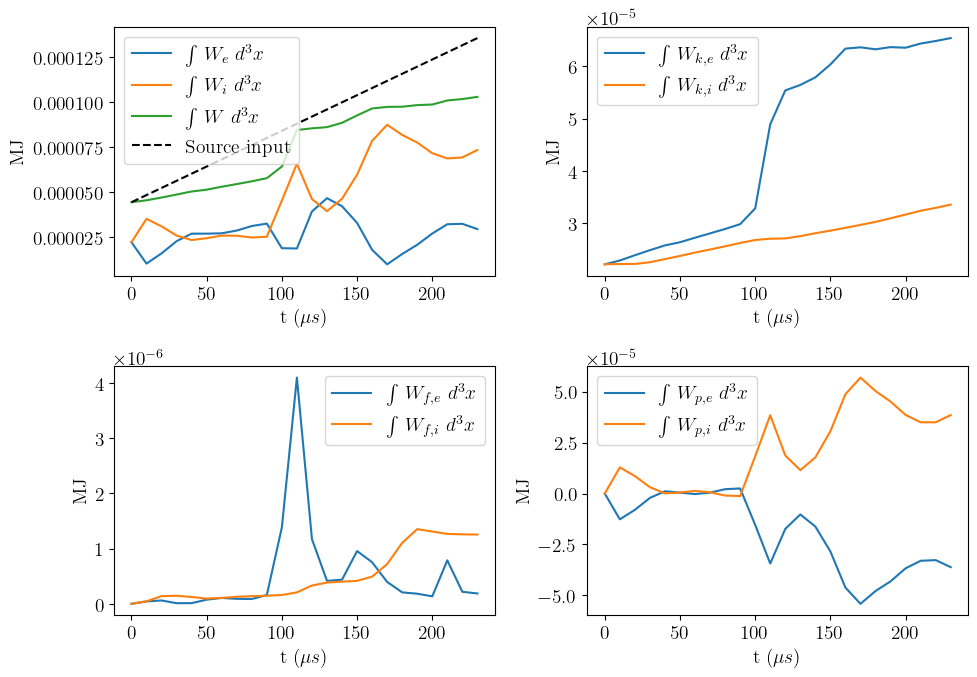

In [14]:
# This format allows to plot different fields on top of eachother
fieldnames = [
    ['Wtote','Wtoti','Wtot'], # total internal energy and per species                 
    ['Wkine','Wkini'], # kinetic energy per species
    ['Wflue','Wflui'], # fluid kinetic energy per species
    ['Wpote','Wpoti'] # potential energy per species
    ]
time_frames = sim_frames[::10] # recommended to avoid computing volume integral for each frames (can be long)
plot_utils.plot_volume_integral_vs_t(
    simulation, fieldnames, time_frames, plot_src_input=True)

### 2.9 Grad B Loss <a id="gradb_loss"></a>
We compute the volume integral of the particle flux, $n v_{\nabla B}$, and energy flux, $n T v_{\nabla B}$, due to the magnetic gradient drift, $v_{\nabla B}$, at the inner radial boundary.
This does not depend on the srcGB parameters

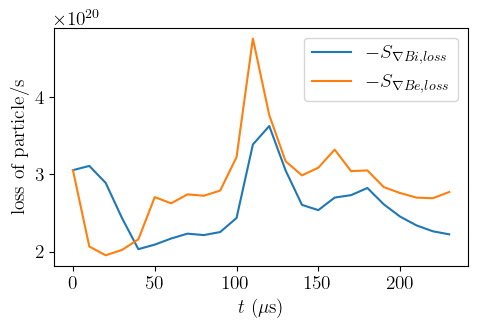

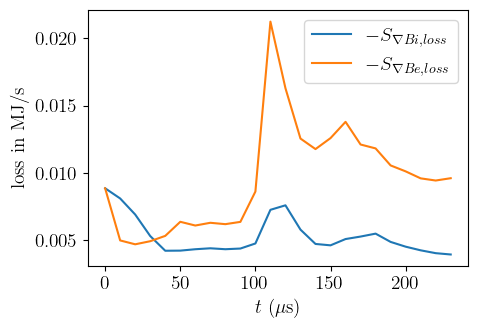

In [15]:
plot_utils.plot_GB_loss(simulation,sim_frames[:-1:10],
                        losstype='particle',integrate=False)
plot_utils.plot_GB_loss(simulation,sim_frames[:-1:10],
                        losstype='energy',integrate=False)

### 2.10 Movie Generator <a id="movie_generator"></a>
Create a movie of 2D cuts over time.

In [16]:
cut_dir = 'xz'
cut_coord = 0.0
time_frames = sim_frames[::4]
fieldnames = ['ne', 'phi', 'Te', 'Ti']
movieprefix = 'my_nice_movie'
plot_utils.make_2D_movie(simulation, cut_dir=cut_dir, cut_coord=cut_coord, time_frames=time_frames, fieldnames=fieldnames)

Processing frames: 58/58... 
movie _movie_ne_phi_Te_Ti_y=0.00.gif created.


### 2.11 Phase Space Analysis <a id="dist_funct"></a>
This is done manually directly with the pgkyl routines. The distribution function files are usually very slow to load.

In [17]:
#---------- 2D cuts of a frame of the distribution function (long to load)
if False: #set it to true if you have some dist function data
    import postgkyl as pg
    # Simulation frame
    tf = sim_frames[-2]
    # Point where each cuts intersect [in Gkeyll units or indices]
    xf = 0.025
    yf = 0.0
    zf = 0.0
    vf = 0.0
    mf = 0.0
    
    for spec in [elc,ion]:
        #---- Load the distf
        fname = simulation.get_filename('f'+spec.nshort,tf)
        data = pg.data.GData(fname)
        dg = pg.data.GInterpModal(data,1,'ms')
        dg.interpolate(0,overwrite=True)

        #---------------- 2D vpar x plots
        cut = copy.copy(data)
        pg.data.select(cut, z1=yf, z2=zf, z4=mf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.vt,
                    title=r"y=%2.2f, z=%2.2f, $\mu$=%2.2f, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$v_\parallel/v_{th%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

        #---------------- 2D mu x plots
        cut = copy.copy(data)
        pg.data.select(cut, z1=yf, z2=zf, z3=vf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.mu0,
                    title=r"y=%2.2f, z=%2.2f, $v_\parallel$=%2.2f, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$\mu B/T_{%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

        #---------------- 2D vpar mu plots
        cut = copy.copy(data)
        pg.data.select(cut, z0=xf, z1=yf, z2=zf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.mu0,
                    title=r"x=%2.2f, y=%2.2f, z=%2.2f, t=%2.2e (s)"%(xf,yf,zf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$v_\parallel/v_{th%s}$'%spec.nshort,ylabel=r'$\mu B/T_{%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);